**Notebook Autor: Souvik Ganguly**

Data generated in previous stage 3. Data_preprocessing.ipynb is used here for Data_preprocessing: /content/drive/MyDrive/Lending_Club_Analysis/data/preprocessed_data.csv <br>

# **This notebook generates:**<br>
**processed_data_for_models.csv: Dataset to be used for segmentation and classification**<br>
**A clustering algorithm that segments the borrowers into 2 different segments**<br>


# **Steps for Segmentation**
**1. Data preparation for clustering:**<br>
>   **Create Dummy Variables**<br>
    **Scale the numerical variables**<br>
    **Feature elimination using variance threshold method and using correlation matrix**<br>

**2. Validate if dataset is relevant for clustering using Hopkin's test**<br>
**3. Export prepared data so that it can be used for classification model as well: processed_data_for_models.csv**<br>
**3. KMeans++ iteration for 3 different kinds of data**<br>


> 1. processed_data_for_models
2. Only numerical variables from processed_data_for_models. Dropping categorical and dummy variables
3. Reduced dimensions: Dimensions of the processed_data_for_models are reduced using Proncipal Component Analysis<br>

**4. For each of the 3 datasets:**

> 1. Determine optimum number of clusters using elbow method
2. Generated silhouette scores for optimum_k-1, optimum_k and optimum_k+1 number of clusters

**5. segmented_processed_data.csv: Based on the optimum cluster number for our problem statement and best silhouette score, final KMeans++ model is created. Segments are assigned to each data points and the final dataset is exported to drive**<br>

# **1. Load python packages and dataset**

In [ ]:
# LIBRARIES -----
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)

In [ ]:
#Mount google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the transactions data
df_preprocessed = pd.read_csv('/content/drive/MyDrive/Lending_Club_Analysis/Output_files/preprocessed_data.csv', low_memory=False)

In [ ]:
df_preprocessed.shape

(1345310, 44)

In [ ]:
#First 5 rows of data
df_preprocessed.head()

,id,dti,revol_util,tot_cur_bal,avg_cur_bal,bc_open_to_buy,mort_acc,num_actv_rev_tl,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_cur_bal_category,avg_cur_bal_category,total_bal_ex_mort_category,total_bc_limit_category,total_il_high_credit_limit_category,inq_last_6mths_binary,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,purpose,delinq_2yrs_category,open_acc,revol_bal,total_acc,perc_loan_paid,recoveries_category,last_fico_range_high,last_fico_range_low,debt_settlement_flag,int_rate_category,installment_category,annual_inc_category,revol_bal_category,last_fico_range_high_category,last_fico_range_low_category,loan_status
0,68407277,3.221603,29.7,36.003101,16.738945,16.837260,0.604321,1.743244,0.000000,26.552149,27.971575,30.868135,82.238313,Medium,Medium,Low,Low,Low,Y,3600.0,3600.0,36 months,13.99,123.03,C,MORTGAGE,55000.0,debt_consolidation,No,7.0,2765.0,13.0,100.0,N,564.0,560.0,N,>10% - <=15%,Low,Low,Low,Poor,Poor,Fully Paid
1,68355089,5.464799,19.2,38.413155,14.827919,40.713790,1.182337,1.958617,3.417456,28.955689,41.947603,93.869043,102.112178,Medium,Medium,Low,High,Low,Y,24700.0,24700.0,36 months,11.99,820.28,C,MORTGAGE,65000.0,small_business,Yes,22.0,21470.0,38.0,100.0,N,699.0,695.0,N,>10% - <=15%,High,Low,Medium,Good,Good,Fully Paid
2,68341763,4.434156,56.2,37.878917,17.874444,19.642289,1.273895,1.484831,9.428180,27.399525,34.911829,42.074228,84.711671,Medium,Medium,Low,Low,Low,N,20000.0,20000.0,60 months,10.78,432.66,B,MORTGAGE,63000.0,home_improvement,No,6.0,7869.0,18.0,100.0,N,704.0,700.0,N,>10% - <=15%,Medium,Low,Low,Good,Good,Fully Paid
3,68476807,6.908813,64.5,42.041101,17.509330,22.332893,1.346200,2.143737,10.304290,30.457479,51.934193,61.374403,162.821420,Medium,Medium,Medium,Medium,Medium,Y,10400.0,10400.0,60 months,22.45,289.91,F,MORTGAGE,104433.0,major_purchase,Yes,12.0,21929.0,35.0,100.0,N,704.0,700.0,N,>20% - <=25%,Low,Medium,Medium,Good,Good,Fully Paid
4,68426831,4.306306,68.4,22.323477,11.771486,14.425313,0.000000,1.484831,13.132012,18.115409,31.761285,48.083118,51.838673,Low,Low,Low,Low,Low,N,11950.0,11950.0,36 months,13.44,405.18,C,RENT,34000.0,debt_consolidation,No,5.0,8822.0,6.0,100.0,N,759.0,755.0,N,>10% - <=15%,Medium,Low,Low,Very Good,Very Good,Fully Paid


# **2. Data Preparation For clustering**

1. **Creating dummy variables** for categorical variables
2. **Scaling the numerical variables** using StandardScaler scaling technique
3. **Feature elimination using variance threshold method:** The variance threshold can be applied to both dummy variables (one-hot encoded categorical variables) and numerical variables. Dummy variables with low variance indicate that the majority of the data points fall into one category, making them less useful for distinguishing between different clusters or classes.The variance threshold method is a simple feature selection technique that removes all features whose variance doesn’t meet a certain threshold. The underlying assumption is that low-variance features are less informative.
4. **Feature elimination using correlation matrix:** Correlation matrix analysis is generally more meaningful for numerical variables. Dummy variables tend to be highly correlated with each other due to the nature of one-hot encoding (e.g., if term_36 is 1, term_60 must be 0). Including dummy variables in correlation matrix analysis might lead to misleading conclusions, so it is often better to apply this method to numerical variables only. The correlation matrix method identifies pairs of features that are highly correlated and removes one feature from each pair. The assumption is that highly correlated features provide redundant information.
5. **Hopkin's Test**
The function hopkins_statistic calculates the Hopkins statistic to evaluate the cluster tendency of the dataset. It prints the Hopkins statistic value.


> *   **Null Hypothesis:** Dataset is uniformly distributed. Hence no meaningful clusters. Average H <=0.85
*   **Alternate Hypotheis:** dataset is not uniformly distributed. Hence It contains meaningful clusters. Average H > 0.85



In [ ]:
# Function to prepare data for clustering
def data_preparation_for_clustering(df, categorical_vars, numerical_vars):
    """
    Prepares the data for clustering by encoding categorical variables and scaling numerical variables.

    Args:
    df (DataFrame): The input dataframe.
    categorical_vars (list): List of categorical variable names.
    numerical_vars (list): List of numerical variable names.

    Returns:
    DataFrame: The prepared dataframe ready for clustering.
    """
    print("Starting data preparation for clustering...")

    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
    print(f"Categorical variables encoded. DataFrame shape: {df_encoded.shape}")

    # Convert boolean dummies to integers (True -> 1, False -> 0)
    df_encoded = df_encoded.astype(int)
    print(f"Converted boolean dummies to integers. DataFrame shape: {df_encoded.shape}")

    # Scale numerical variables
    scaler = StandardScaler()
    df_encoded[numerical_vars] = scaler.fit_transform(df_encoded[numerical_vars])
    print(f"Numerical variables scaled. DataFrame shape: {df_encoded.shape}")

    return df_encoded


# Feature Elimination using Variance Threshold
def variance_threshold_selector(data, threshold=0.01):
    print("Applying variance threshold selector...")
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    data = data[data.columns[selector.get_support(indices=True)]]
    print(f"Variance threshold applied. Remaining features: {data.shape[1]}")
    return data

# Feature Elimination using Correlation Matrix
def remove_highly_correlated_features(data, threshold=0.9):
    print("Removing highly correlated features...")
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    data = data.drop(to_drop, axis=1)
    print(f"Highly correlated features removed. Remaining features: {data.shape[1]}")
    return data

# Hopkins Test to check the cluster tendency of the dataset
def hopkins_statistic(X, sample_size=None):
    """
    Calculates the Hopkins statistic for a given dataset to evaluate its cluster tendency.

    Parameters:
    X (DataFrame): The input data.
    sample_size (int): The number of data points to sample. Default is 10% of the dataset.

    Returns:
    float: The Hopkins statistic.
    """
    print("Calculating Hopkins statistic...")

    # Ensure all data is numeric
    X = X.select_dtypes(include=[np.number])

    d = X.shape[1]
    n = len(X)

    # Set sample size to 10% of the dataset if not provided
    if sample_size is None:
        sample_size = int(0.1 * n)

    if sample_size > n:
        raise ValueError("Sample size can't be larger than the dataset size.")

    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    # Generate random points
    rand_X = np.random.rand(sample_size, d) * (X.max().values - X.min().values) + X.min().values
    ujd = []
    wjd = []

    for j in range(sample_size):
        u_dist, _ = nbrs.kneighbors([rand_X[j]], 2, return_distance=True)
        w_dist, _ = nbrs.kneighbors([X.sample(1).values[0]], 2, return_distance=True)
        ujd.append(u_dist[0][1])
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    print(f"Hopkins Statistic: {H}")
    return H

In [ ]:
# Define the categorical and numerical variables
categorical_vars = ['tot_cur_bal_category', 'avg_cur_bal_category', 'total_bal_ex_mort_category', 'total_bc_limit_category',
                    'total_il_high_credit_limit_category', 'inq_last_6mths_binary', 'term', 'grade', 'home_ownership',
                    'purpose', 'delinq_2yrs_category', 'recoveries_category', 'debt_settlement_flag', 'int_rate_category',
                    'installment_category', 'annual_inc_category', 'revol_bal_category', 'last_fico_range_high_category',
                    'last_fico_range_low_category']

numerical_vars = ['dti', 'revol_util', 'tot_cur_bal', 'avg_cur_bal', 'bc_open_to_buy', 'mort_acc', 'num_actv_rev_tl',
                  'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
                  'loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'open_acc', 'revol_bal', 'total_acc',
                  'perc_loan_paid', 'last_fico_range_high', 'last_fico_range_low']


In [ ]:
# Prepare the data
# df_prepared = data_preparation_for_clustering(df_preprocessed.drop(columns=['id', 'loan_status']), categorical_vars, numerical_vars)

# # Save 'id' and 'loan_status' columns for later mapping
# ids = df_preprocessed['id']
# loan_status = df_preprocessed['loan_status']

# # Apply variance threshold selector
# df_prepared = variance_threshold_selector(df_prepared)

# # Remove highly correlated features
# df_prepared = remove_highly_correlated_features(df_prepared)

Starting data preparation for clustering...
Categorical variables encoded. DataFrame shape: (1345310, 94)
Converted boolean dummies to integers. DataFrame shape: (1345310, 94)
Numerical variables scaled. DataFrame shape: (1345310, 94)
Applying variance threshold selector...
Variance threshold applied. Remaining features: 72
Removing highly correlated features...
Highly correlated features removed. Remaining features: 64


In [ ]:
# df_prepared['id']=ids.values
# df_prepared['loan_status']=loan_status

In [ ]:
# Prepare the data
df_prepared = data_preparation_for_clustering(df_preprocessed.drop(columns=['id', 'loan_status']), categorical_vars, numerical_vars)

# Save 'id' and 'loan_status' columns for later mapping
ids = df_preprocessed['id']
loan_status = df_preprocessed['loan_status']

# Apply variance threshold selector
df_prepared = variance_threshold_selector(df_prepared)

# Remove highly correlated features
df_prepared = remove_highly_correlated_features(df_prepared)

# Apply Hopkins Test
for i in range(1,6):
  hopkins_score = hopkins_statistic(df_prepared, sample_size=1000)
  print(f"Hopkins Statistic: {hopkins_score}")

Starting data preparation for clustering...
Categorical variables encoded. DataFrame shape: (1345310, 94)
Converted boolean dummies to integers. DataFrame shape: (1345310, 94)
Numerical variables scaled. DataFrame shape: (1345310, 94)
Applying variance threshold selector...
Variance threshold applied. Remaining features: 72
Removing highly correlated features...
Highly correlated features removed. Remaining features: 64
Calculating Hopkins statistic...
Hopkins Statistic: 0.9648238978692573
Hopkins Statistic: 0.9648238978692573
Calculating Hopkins statistic...
Hopkins Statistic: 0.9667271706377367
Hopkins Statistic: 0.9667271706377367
Calculating Hopkins statistic...
Hopkins Statistic: 0.9651389560040534
Hopkins Statistic: 0.9651389560040534
Calculating Hopkins statistic...
Hopkins Statistic: 0.965542978391139
Hopkins Statistic: 0.965542978391139
Calculating Hopkins statistic...
Hopkins Statistic: 0.9646249880857238
Hopkins Statistic: 0.9646249880857238


In [ ]:
df_prepared['id']=ids.values
df_prepared['loan_status']=loan_status

# Export the DataFrame ready for ML algorithms to Google Drive
output_path = '/content/drive/MyDrive/Lending_Club_Analysis/Output_files/processed_data_for_models.csv'
df_prepared.to_csv(output_path, index=False)

print(f"DataFrame exported successfully to {output_path}")

DataFrame exported successfully to /content/drive/MyDrive/Lending_Club_Analysis/Output_files/processed_data_for_models.csv


# **3. Segmentation: KMeans++ Clustering Algorithm**

# **KMeans ++**
1. Elbow Method: Determine the optimal number of clusters.
2. Clustering with Optimal Clusters: Perform clustering for the optimal number of clusters, one less, and one more.
3. Profiling and Visualization: Profile the clusters, visualize the clustered data, and perform Silhouette analysis.

In [ ]:
df_prepared.drop(['id', 'loan_status'], axis=1, inplace=True)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Elbow method to determine the optimal number of clusters
def elbow_method(data):
    """
    Determines the optimal number of clusters using the Elbow method.

    Args:
    data (DataFrame): The input dataframe.

    Returns:
    int: The optimal number of clusters.
    """
    print("Determining the optimal number of clusters using the Elbow method...")
    inertia = []
    K = range(1, 15)
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

    return None



#Function to Calculate Silhouette score and plot a graph for Silhouette coefficient for every cluster for
#different number of clusters

def Silhouette_Analysis(df, k):
    """
    Performs Silhouette Analysis for KMeans clustering.

    Args:
    df (array-like): The input data.
    k (int): The initial number of clusters.

    Returns:
    str: Recommendation message.
    """
    print("Starting Silhouette Analysis...")

    if k == 2:
        range_n_clusters = [k, k + 1, k + 2]
    elif k > 2:
        range_n_clusters = [k - 1, k, k + 1]
    else:
        print("Invalid value of k cluster_number")
        return None

    for n_clusters in range_n_clusters:
        print(f"Analyzing for n_clusters = {n_clusters}...")

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 42 for reproducibility
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=42)
        cluster_labels = clusterer.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        silhouette_avg = silhouette_score(df, cluster_labels)
        print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(df[:, 0], df[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        centers = clusterer.cluster_centers_
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans++ clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

    return 'Choose the optimum value of K'


def kmeans_clustering(data, k, sample_size=130000):
  """
  Performs KMeans++ clustering and profiles the clusters.

  Args:
  data (DataFrame): The input dataframe.
  k (int): The number of clusters.

  Returns:
  KMeans: The fitted KMeans model.
  """
  print(f"Performing KMeans++ clustering with {k} clusters...")
  kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=42)
  data['Cluster'] = kmeans.fit_predict(data)
  print(f"KMeans++ clustering with {k} clusters completed.")

  # Sample the data for silhouette score calculation
  if len(data) > sample_size:
      data_sample = data.sample(n=sample_size, random_state=42)
  else:
      data_sample = data

  # Silhouette analysis
  silhouette_avg = silhouette_score(data_sample.drop(columns=['Cluster']), data_sample['Cluster'])
  print(f"Silhouette Score for {k} clusters: {silhouette_avg}")

  # Cluster profiling
  cluster_profiles = data.groupby('Cluster').describe().T
  print("Cluster profiles generated \n")

  return cluster_profiles

# **3.1 KMeans++ clustering using df_prepared(dataset with numerical variables and dummy variables)**

Determining the optimal number of clusters using the Elbow method...


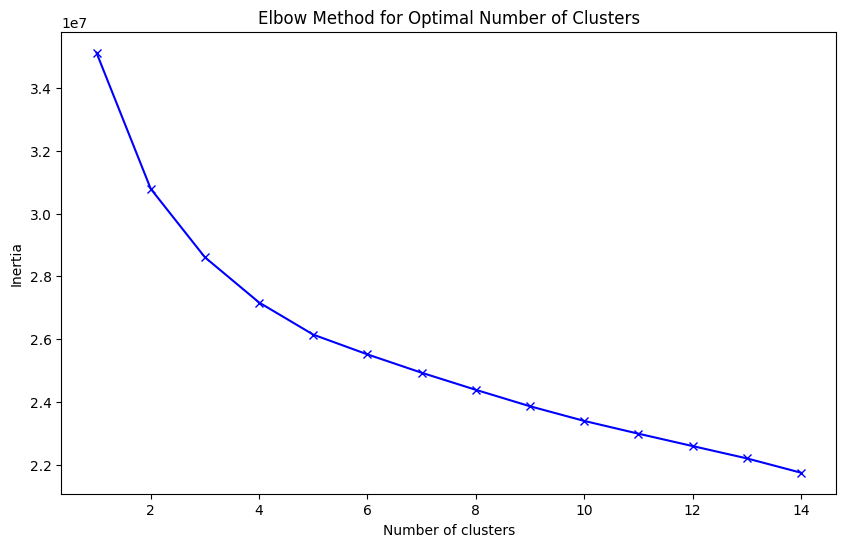

In [ ]:
# Determine the optimal number of clusters using the Elbow method
elbow_method(df_prepared)

As per the elbow method, the optimal number of clusters are 2, 3 and 4

In [ ]:
# Perform KMeans++ clustering for k_optimal-1, k_optimal, k_optimal+1
k_optimal=3
cluster_profiles_dict = {}
for k in [k_optimal-1, k_optimal, k_optimal+1]:
    cluster_profiles_dict[k]=kmeans_clustering(df_prepared.copy(), k)

Performing KMeans++ clustering with 2 clusters...
KMeans++ clustering with 2 clusters completed.
Silhouette Score for 2 clusters: 0.12211212566530005
Cluster profiles generated 

Performing KMeans++ clustering with 3 clusters...
KMeans++ clustering with 3 clusters completed.
Silhouette Score for 3 clusters: 0.11244779360081943
Cluster profiles generated 

Performing KMeans++ clustering with 4 clusters...
KMeans++ clustering with 4 clusters completed.
Silhouette Score for 4 clusters: 0.0811661264208567
Cluster profiles generated 



# **3.2 KMeans++ clustering using only numerical variables**

In [ ]:
df_preprocessed.head()

,id,dti,revol_util,tot_cur_bal,avg_cur_bal,bc_open_to_buy,mort_acc,num_actv_rev_tl,percent_bc_gt_75,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,tot_cur_bal_category,avg_cur_bal_category,total_bal_ex_mort_category,total_bc_limit_category,total_il_high_credit_limit_category,inq_last_6mths_binary,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,purpose,delinq_2yrs_category,open_acc,revol_bal,total_acc,perc_loan_paid,recoveries_category,last_fico_range_high,last_fico_range_low,debt_settlement_flag,int_rate_category,installment_category,annual_inc_category,revol_bal_category,last_fico_range_high_category,last_fico_range_low_category,loan_status
0,68407277,3.221603,29.7,36.003101,16.738945,16.837260,0.604321,1.743244,0.000000,26.552149,27.971575,30.868135,82.238313,Medium,Medium,Low,Low,Low,Y,3600.0,3600.0,36 months,13.99,123.03,C,MORTGAGE,55000.0,debt_consolidation,No,7.0,2765.0,13.0,100.0,N,564.0,560.0,N,>10% - <=15%,Low,Low,Low,Poor,Poor,Fully Paid
1,68355089,5.464799,19.2,38.413155,14.827919,40.713790,1.182337,1.958617,3.417456,28.955689,41.947603,93.869043,102.112178,Medium,Medium,Low,High,Low,Y,24700.0,24700.0,36 months,11.99,820.28,C,MORTGAGE,65000.0,small_business,Yes,22.0,21470.0,38.0,100.0,N,699.0,695.0,N,>10% - <=15%,High,Low,Medium,Good,Good,Fully Paid
2,68341763,4.434156,56.2,37.878917,17.874444,19.642289,1.273895,1.484831,9.428180,27.399525,34.911829,42.074228,84.711671,Medium,Medium,Low,Low,Low,N,20000.0,20000.0,60 months,10.78,432.66,B,MORTGAGE,63000.0,home_improvement,No,6.0,7869.0,18.0,100.0,N,704.0,700.0,N,>10% - <=15%,Medium,Low,Low,Good,Good,Fully Paid
3,68476807,6.908813,64.5,42.041101,17.509330,22.332893,1.346200,2.143737,10.304290,30.457479,51.934193,61.374403,162.821420,Medium,Medium,Medium,Medium,Medium,Y,10400.0,10400.0,60 months,22.45,289.91,F,MORTGAGE,104433.0,major_purchase,Yes,12.0,21929.0,35.0,100.0,N,704.0,700.0,N,>20% - <=25%,Low,Medium,Medium,Good,Good,Fully Paid
4,68426831,4.306306,68.4,22.323477,11.771486,14.425313,0.000000,1.484831,13.132012,18.115409,31.761285,48.083118,51.838673,Low,Low,Low,Low,Low,N,11950.0,11950.0,36 months,13.44,405.18,C,RENT,34000.0,debt_consolidation,No,5.0,8822.0,6.0,100.0,N,759.0,755.0,N,>10% - <=15%,Medium,Low,Low,Very Good,Very Good,Fully Paid


In [ ]:
df_preprocessed.columns

Index(['id', 'dti', 'revol_util', 'tot_cur_bal', 'avg_cur_bal',
       'bc_open_to_buy', 'mort_acc', 'num_actv_rev_tl', 'percent_bc_gt_75',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'tot_cur_bal_category',
       'avg_cur_bal_category', 'total_bal_ex_mort_category',
       'total_bc_limit_category', 'total_il_high_credit_limit_category',
       'inq_last_6mths_binary', 'loan_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'home_ownership', 'annual_inc',
       'purpose', 'delinq_2yrs_category', 'open_acc', 'revol_bal', 'total_acc',
       'perc_loan_paid', 'recoveries_category', 'last_fico_range_high',
       'last_fico_range_low', 'debt_settlement_flag', 'int_rate_category',
       'installment_category', 'annual_inc_category', 'revol_bal_category',
       'last_fico_range_high_category', 'last_fico_range_low_category',
       'loan_status'],
      dtype='object')

In [ ]:
#creating a new dataframe with only numerical variables
df_numerical=df_prepared[['dti', 'revol_util', 'tot_cur_bal', 'bc_open_to_buy', 'mort_acc', 'num_actv_rev_tl', 'percent_bc_gt_75',
                              'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'int_rate', 'annual_inc', 'open_acc', 'revol_bal',
                              'total_acc', 'perc_loan_paid', 'last_fico_range_high', 'last_fico_range_low']]

Determining the optimal number of clusters using the Elbow method...


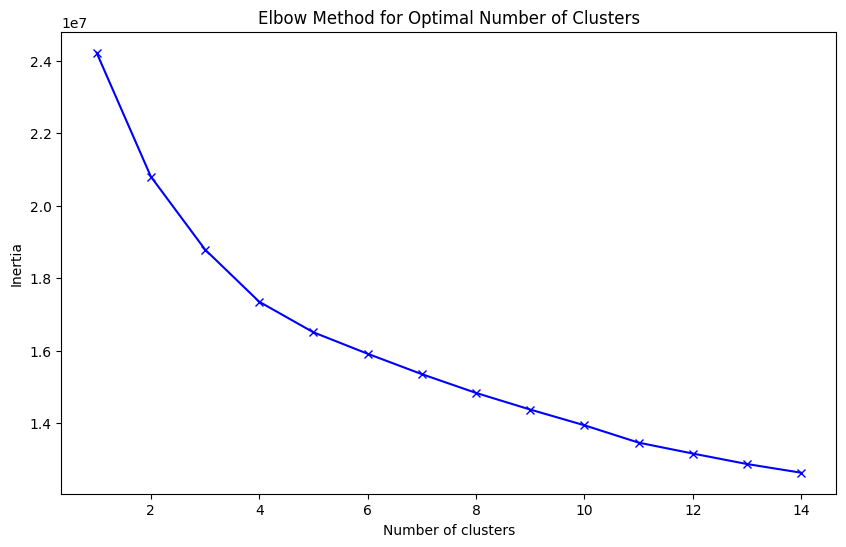

In [ ]:
# Determine the optimal number of clusters using the Elbow method
elbow_method(df_numerical)

As per the elbow method, the optimal number of clusters are 2, 3 and 4

In [ ]:
# Perform KMeans++ clustering for k_optimal-1, k_optimal, k_optimal+1
k_optimal=3
cluster_profiles_dict = {}
for k in [k_optimal-1, k_optimal, k_optimal+1]:
    cluster_profiles_dict[k]=kmeans_clustering(df_numerical.copy(), k)

Performing KMeans++ clustering with 2 clusters...
KMeans++ clustering with 2 clusters completed.
Silhouette Score for 2 clusters: 0.13989468736643357
Cluster profiles generated 

Performing KMeans++ clustering with 3 clusters...
KMeans++ clustering with 3 clusters completed.
Silhouette Score for 3 clusters: 0.14029786835490982
Cluster profiles generated 

Performing KMeans++ clustering with 4 clusters...
KMeans++ clustering with 4 clusters completed.
Silhouette Score for 4 clusters: 0.1162756039805681
Cluster profiles generated 



# **3.2 KMeans++ clustering using reduced dimensions(Dimensions are reduced using the Principal Component Analysis Technique)**

# **Principal Component Analysis PCA**

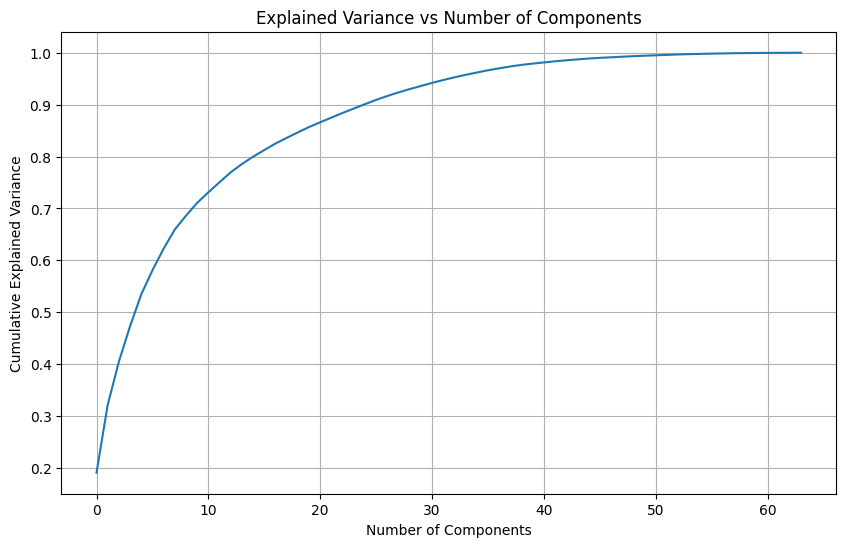

In [ ]:
#Apply PCA to the standardized data and compute the explained variance.

from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
pca.fit(df_prepared)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()

In [ ]:
# Determine the Number of Components
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Find the number of components that explain at least 80% variance
n_components = np.where(cumulative_explained_variance >= 0.8)[0][0] + 1
print(f'Number of components to retain 80% variance: {n_components}')

Number of components to retain 80% variance: 16


In [ ]:
# Reduce Dimensions
# Transform data to the reduced number of dimensions
pca = PCA(n_components=n_components)
df_reduced = pca.fit_transform(df_prepared)

# Optional: Convert back to DataFrame if needed
df_reduced = pd.DataFrame(df_reduced)
print(df_reduced.shape)

(1345310, 16)


In [ ]:
df_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-2.896413,-0.287776,-0.475370,-0.485846,1.988492,-1.265024,0.135524,0.056341,1.212509,-1.454696,-0.228973,-0.740337,0.947675,0.397270,-0.132723,0.105927
1,2.939795,-2.009765,-1.670000,0.413080,0.229281,-1.109362,-0.963129,-1.228739,-0.012724,0.379478,-0.222863,-0.600515,-0.472426,1.550494,-0.078061,-0.003621
2,-0.653721,-0.629073,1.681255,0.997176,1.438868,-1.327472,-0.552761,-0.922803,-0.809738,0.208695,-0.208705,-0.259382,0.874582,0.401507,-0.174552,-0.044699
3,2.810854,1.338291,1.197570,-0.329554,0.221898,-0.866341,-1.171027,-0.388635,1.314289,0.092774,-1.215883,0.094776,-1.363049,-1.053421,-0.075824,-0.457510
4,-3.103627,-0.576090,1.817474,1.148585,-1.022094,0.850912,-0.294898,-0.078954,-0.714908,0.180934,0.157035,0.382025,0.002765,0.173610,-0.452167,0.782178


Determining the optimal number of clusters using the Elbow method...


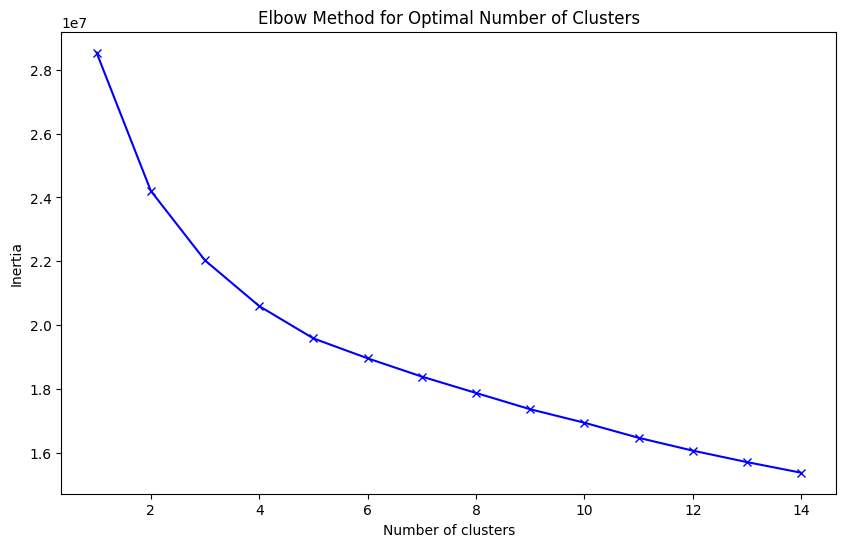

In [ ]:
# Determine the optimal number of clusters using the Elbow method on the reduced dimensions
elbow_method(df_reduced)

Based on the elbow curve, number of logical clusters seems close to 3 and 4. Hence performing silhouette analysis with reduced dimensions for k = 2, 3 and 4

In [ ]:
# Perform KMeans++ clustering for k_optimal-1, k_optimal, k_optimal+1
k_optimal=3
cluster_profiles_dict = {}
for k in [k_optimal-1, k_optimal, k_optimal+1]:
    cluster_profiles_dict[k]=kmeans_clustering(df_reduced.copy(), k)

Performing KMeans++ clustering with 2 clusters...
KMeans++ clustering with 2 clusters completed.
Silhouette Score for 2 clusters: 0.14876004792456368
Cluster profiles generated 

Performing KMeans++ clustering with 3 clusters...
KMeans++ clustering with 3 clusters completed.
Silhouette Score for 3 clusters: 0.14093328381569584
Cluster profiles generated 

Performing KMeans++ clustering with 4 clusters...
KMeans++ clustering with 4 clusters completed.
Silhouette Score for 4 clusters: 0.10913289049958579
Cluster profiles generated 



# **3.4 Creating the most optimal segments**

# **All the iterations of clustering tested using Elbow method and Silhouette Analysis**

1. In all the 3 cases the optimum number of clusters is 2
2. The Silhouette score is highest with reduced features using PCA followed by clustering using only numerical variables followed by clustering with all the features is df_preprocessed. After discussion with stakeholders and their approval, we will cluster the using numerical variables

In [ ]:
#check the df_prepared dataframe since the labels will be appended in df_prepared
df_prepared['id']=ids.values
df_prepared['loan_status']=loan_status
df_prepared.head()

,dti,revol_util,tot_cur_bal,bc_open_to_buy,mort_acc,num_actv_rev_tl,percent_bc_gt_75,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_amnt,int_rate,annual_inc,open_acc,revol_bal,total_acc,perc_loan_paid,last_fico_range_high,last_fico_range_low,tot_cur_bal_category_Low,tot_cur_bal_category_Medium,avg_cur_bal_category_Low,avg_cur_bal_category_Medium,total_bal_ex_mort_category_Low,total_bal_ex_mort_category_Medium,total_bc_limit_category_Low,total_bc_limit_category_Medium,total_bc_limit_category_No Balance,total_il_high_credit_limit_category_Low,total_il_high_credit_limit_category_Medium,total_il_high_credit_limit_category_No Balance,inq_last_6mths_binary_Y,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,delinq_2yrs_category_Yes,recoveries_category_Y,debt_settlement_flag_Y,int_rate_category_>15% - <=20%,int_rate_category_>20% - <=25%,int_rate_category_>25%,int_rate_category_>5% - <=10%,installment_category_Low,installment_category_Medium,annual_inc_category_Low,annual_inc_category_Medium,revol_bal_category_Low,revol_bal_category_Medium,last_fico_range_high_category_Fair,last_fico_range_high_category_Good,last_fico_range_high_category_Poor,last_fico_range_high_category_Very Good,id,loan_status
0,-1.360931,-0.912951,0.548231,-0.706737,-0.603443,-0.654817,-1.406912,-1.597810,-1.496790,-0.471603,-1.241243,0.071780,-0.303863,-0.839185,-0.603861,-0.998531,0.472896,-1.391835,-0.754413,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,68407277,Fully Paid
1,-0.083447,-1.320890,0.816809,2.086000,1.657158,-0.654817,-0.786043,0.004968,2.086159,-0.079045,1.179302,-0.348933,-0.160853,1.901148,0.233870,1.085069,0.472896,0.266775,0.262389,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,68355089,Fully Paid
2,-0.722189,0.188482,0.682520,-0.357645,1.657158,-0.654817,0.455694,-0.796421,-0.814324,-0.432347,0.640128,-0.559289,-0.189455,-1.021874,-0.375271,-0.581811,0.472896,0.328205,0.300048,0,1,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,68341763,Fully Paid
3,0.555295,0.514833,1.353966,-0.008553,1.657158,0.941242,0.662650,1.149809,0.266249,1.098630,-0.461162,1.964988,0.403080,0.074259,0.254427,0.835037,0.472896,0.328205,0.300048,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,68476807,Fully Paid
4,-0.722189,0.678008,-1.331819,-0.939465,-0.603443,-0.654817,1.283518,-1.139873,-0.473090,-1.080068,-0.283350,0.071780,-0.604184,-1.204563,-0.332590,-1.581938,0.472896,1.003935,0.714300,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,68426831,Fully Paid


In [ ]:
df_prepared.shape

(1345310, 66)

In [ ]:
df_numerical.columns

Index(['dti', 'revol_util', 'tot_cur_bal', 'bc_open_to_buy', 'mort_acc',
       'num_actv_rev_tl', 'percent_bc_gt_75', 'total_bal_ex_mort',
       'total_bc_limit', 'total_il_high_credit_limit', 'int_rate',
       'annual_inc', 'open_acc', 'revol_bal', 'total_acc', 'perc_loan_paid',
       'last_fico_range_high', 'last_fico_range_low'],
      dtype='object')

In [ ]:
#Generating KMeans++ model with 2 clusters on numerical features of the dataset

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=50, random_state=42)
df_numerical['Cluster'] = kmeans.fit_predict(df_numerical)
print(f"KMeans++ clustering with {k} clusters completed.")

#Append the Cluster labels to our main dataframe
df_prepared['KMeans_Cluster']=kmeans.labels_
df_prepared.head()

KMeans++ clustering with 4 clusters completed.


,dti,revol_util,tot_cur_bal,bc_open_to_buy,mort_acc,num_actv_rev_tl,percent_bc_gt_75,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_amnt,int_rate,annual_inc,open_acc,revol_bal,total_acc,perc_loan_paid,last_fico_range_high,last_fico_range_low,tot_cur_bal_category_Low,tot_cur_bal_category_Medium,avg_cur_bal_category_Low,avg_cur_bal_category_Medium,total_bal_ex_mort_category_Low,total_bal_ex_mort_category_Medium,total_bc_limit_category_Low,total_bc_limit_category_Medium,total_bc_limit_category_No Balance,total_il_high_credit_limit_category_Low,total_il_high_credit_limit_category_Medium,total_il_high_credit_limit_category_No Balance,inq_last_6mths_binary_Y,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,delinq_2yrs_category_Yes,recoveries_category_Y,debt_settlement_flag_Y,int_rate_category_>15% - <=20%,int_rate_category_>20% - <=25%,int_rate_category_>25%,int_rate_category_>5% - <=10%,installment_category_Low,installment_category_Medium,annual_inc_category_Low,annual_inc_category_Medium,revol_bal_category_Low,revol_bal_category_Medium,last_fico_range_high_category_Fair,last_fico_range_high_category_Good,last_fico_range_high_category_Poor,last_fico_range_high_category_Very Good,id,loan_status,KMeans_Cluster
0,-1.360931,-0.912951,0.548231,-0.706737,-0.603443,-0.654817,-1.406912,-1.597810,-1.496790,-0.471603,-1.241243,0.071780,-0.303863,-0.839185,-0.603861,-0.998531,0.472896,-1.391835,-0.754413,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,68407277,Fully Paid,0
1,-0.083447,-1.320890,0.816809,2.086000,1.657158,-0.654817,-0.786043,0.004968,2.086159,-0.079045,1.179302,-0.348933,-0.160853,1.901148,0.233870,1.085069,0.472896,0.266775,0.262389,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,68355089,Fully Paid,1
2,-0.722189,0.188482,0.682520,-0.357645,1.657158,-0.654817,0.455694,-0.796421,-0.814324,-0.432347,0.640128,-0.559289,-0.189455,-1.021874,-0.375271,-0.581811,0.472896,0.328205,0.300048,0,1,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,68341763,Fully Paid,0
3,0.555295,0.514833,1.353966,-0.008553,1.657158,0.941242,0.662650,1.149809,0.266249,1.098630,-0.461162,1.964988,0.403080,0.074259,0.254427,0.835037,0.472896,0.328205,0.300048,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,68476807,Fully Paid,1
4,-0.722189,0.678008,-1.331819,-0.939465,-0.603443,-0.654817,1.283518,-1.139873,-0.473090,-1.080068,-0.283350,0.071780,-0.604184,-1.204563,-0.332590,-1.581938,0.472896,1.003935,0.714300,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,68426831,Fully Paid,0


In [ ]:
# Export the DataFrame ready for Classification to Google Drive
output_path = '/content/drive/MyDrive/Lending_Club_Analysis/Output_files/segmented_processed_data.csv'
df_prepared.to_csv(output_path, index=False)

print(f"DataFrame exported successfully to {output_path}")

DataFrame exported successfully to /content/drive/MyDrive/Lending_Club_Analysis/Output_files/segmented_processed_data.csv
